<a href="https://colab.research.google.com/github/antonercool/deep-learning-exam-project/blob/master/FallDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning course project - Fall Detection




###Group members


*   Anton Sihm, studentId.: 201504954
*   Peter Marcus Hoveling, studentId.: 201508876







###Purpose

This project aims to detect human actions from live video feed, in order to achieve safety, such as
alarms when elderly people fall in their apartments.








---



### Data sets

To evaluate the fall detection, dataset from realistic video surveillance settings will be used. Framerate
and resolution may vary as finding the same formatted video data is challenging


*   mViA - Fall detection dataset



## Mounting Google Drive data


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Creating a variable to the specific files mouted

In [2]:
from pathlib import Path
root = '/content/gdrive/My Drive/' # Don't change this
data_dirname = 'Data_complete' # Change as you like
p = Path(root + data_dirname)
p.mkdir(exist_ok=True) # should "/content/gdrive/My Drive/Data"

Validating the data directory

In [3]:
print(p)

/content/gdrive/My Drive/Data_complete


## Download data 

Download data set and unpack into /Data_complete
* https://imvia.u-bourgogne.fr/en/database/fall-detection-dataset-2.html
* We made some correction to the dataset, since a few of the videos was missing labels.

---

## Utility functions
 * Convert video to frames
 * Normalize data to be within 0-1
 * Center crop images
 * Partion videos into training & testing
 * Get paths to all training & testing videos
  - *Must have root path to dataset*

In [4]:
# Importing all necessary libraries
import cv2
import os
import numpy 
import random

class VideoUtils:

  def __init__(self):
    pass

  def convert_single_video_to_images(self, video_path, annotation_path, dim):
    # Read the video from specified path
    video = cv2.VideoCapture(video_path)
    meta_data = open(annotation_path)

    start_fall_frame = meta_data.readline() 
    end_fall_frame = meta_data.readline() 

    not_falling = False
    # check if has labels
    if "," in start_fall_frame:
      #print(f"does not contain : {annotation_path}")
      ## skip current
      not_falling = True
      start_fall_frame = 0
      end_fall_frame = 0
    else:
      start_fall_frame = int(start_fall_frame)
      end_fall_frame = int(end_fall_frame)  

    traning_samples = []
    training_labels = []

    currentframe = 0

    while(True):

      # reading from frame
      ret,frame = video.read()
      if ret:
        if(frame.shape[0] != dim[0] or frame.shape[1] != dim[1]):
          try:
            frame = self.center_crop(frame, dim)
          except e:
            print(f"failed to center from image from vid : {video_path}, error {e}")

        traning_samples.append(frame)

        if not_falling == False:
          # if falling - label 1
          if currentframe >= start_fall_frame and currentframe <= end_fall_frame:
            training_labels.append(1)
          # not falling - label 0
          else:
            training_labels.append(0)
        else:
          training_labels.append(0)

        # increasing counter so that it will
        # show how many frames are created
        currentframe += 1
      else:
        break

    # Release all space and windows once done
    video.release()
    cv2.destroyAllWindows()

    traning_samples = numpy.array(traning_samples)
    training_labels =  numpy.array(training_labels)

    return (traning_samples, training_labels, True)

  # Function from: https://medium.com/curious-manava/center-crop-and-scaling-in-opencv-using-python-279c1bb77c74
  def center_crop(self, img, dim):
	  """Returns center cropped image
	  Args:
	  img: image to be center cropped
	  dim: dimensions (width, height) to be cropped
	  """
	  width, height = img.shape[1], img.shape[0]

	  # process crop width and height for max available dimension
	  crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
	  crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
	  mid_x, mid_y = int(width/2), int(height/2)
	  cw2, ch2 = int(crop_width/2), int(crop_height/2) 
	  crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
	  return crop_img


  def _get_movie_IDs(self, root_path):
    list_video_paths = []
    annotation_path = r"/Annotation_files"
    video_path = r"/Videos"
    
    data_sub_dir = os.listdir(root_path)

    # interate each sub dir
    # ignore .pyinb and model folder
    for dir in data_sub_dir:
      if ".ipynb" in dir:
        continue
      if "model" in dir:
        continue  
      if "test_images" in dir:
        continue
      # for each file in sub dir
      for file in os.listdir(str(root_path) + "/" + dir + video_path):
        absolute_video_file_path = str(str(root_path) + "/" + dir + video_path + "/"+ file)
        list_video_paths.append(absolute_video_file_path)

    return list_video_paths


  def normalize_image(self, image):
    # normalizing values between 0 - 1
    image = image.astype('float32')
    return image/255.0

  # create_partition_list(p)
  def create_partition_list(self, root_path, traning_percentage=80, validation_percentage=20):
    partition = {}

    absolute_video_path_list = video_utils._get_movie_IDs(root_path)
    #random.shuffle(absolute_video_path_list)

    to_index = int((len(absolute_video_path_list)+1)*(traning_percentage/100))
    from_index = int(len(absolute_video_path_list)*(traning_percentage/100)+1)

    print(f"traning {0}:{to_index}")
    print(f"validation {from_index}:{len(absolute_video_path_list)}")

    training = absolute_video_path_list[0:to_index]
    validation = absolute_video_path_list[from_index:]

    total_frames_training = 0
    total_frames_validation = 0
    
    for image_path in training:
      cap= cv2.VideoCapture(image_path)
      total_frames_training += int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for image_path in validation:
      cap= cv2.VideoCapture(image_path)
      total_frames_validation += int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    
    partition['Training'] = (training, total_frames_training)
    partition['Validation'] = (validation, total_frames_validation)

    return partition

---
## Dataset exploration



### Analyse Falling vs. not-falling class distribution

Inspect the distribution - 9 mins to run

In [5]:
video_utils = VideoUtils()

# Falling vs. not-falling class distribution       //9 mins to run
total_movies_to_fetch = video_utils._get_movie_IDs(p)

print(f"Total movies: {len(total_movies_to_fetch)}")
label_0_count = 0
label_1_count = 0


for movie in total_movies_to_fetch:
  annotation_path = movie.replace("Videos", "Annotation_files")
  annotation_path = annotation_path.replace(".avi", ".txt")

  samples, labels, _ = video_utils.convert_single_video_to_images(movie, annotation_path, (180, 180))

  label_0_count += labels.tolist().count(0)
  label_1_count += labels.tolist().count(1)

print(f"Total number of 'Not-Falling' samples: {label_0_count}")
print(f"Total number of 'Falling' samples: {label_1_count}")
print(f"{(label_1_count/(label_1_count + label_0_count))*100}% is falling")

Total movies: 190
Total number of 'Not-Falling' samples: 71883
Total number of 'Falling' samples: 4028
5.306213855699438% is falling


## Dataloader
* Since data is too large to fit in memory, a dataloader is needed.

### Dataloader class creation

In [6]:
import numpy as np
import keras
from tensorflow.keras.utils import Sequence
from keras import utils as np_utils
from keras.applications.mobilenet import preprocess_input
import random

class FallingDataGenerator(Sequence):

  def __init__(self, movie_path_list, total_movie_frames, batch_size=32, dim=(240, 320), n_channels=3, n_classes=2, shuffle=True, preprocessor=False): 
      'Initialization'
      self.dim = dim
      self.batch_size = batch_size
      self.n_channels = n_channels
      self.n_classes = n_classes
      self.shuffle = shuffle
      self.movie_path_list = movie_path_list
      self.total_movie_frames = total_movie_frames
      self.current_video_data = 0   
      self.current_video_frame = 0
      self.current_movie_index = 0
      self.video_utils = VideoUtils()
      self.current_batch = 0
      self.preprocessor = preprocessor

      # init by shuffle
      self.on_epoch_end()

  def reset(self):
    self.current_video_data = 0
    self.current_video_frame = 0
    self.current_movie_index = 0

  # Shuffling the order in which examples are fed to the classifier is helpful so that batches between epochs do not look alike
  def on_epoch_end(self):
    'Updates indexes after each epoch'
    random.shuffle(self.movie_path_list)
    self.current_video_data = 0
    self.current_video_frame = 0
    self.current_movie_index = 0


  def __data_generation(self):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.zeros((self.batch_size, *self.dim, self.n_channels)) # (32, H, W, 3)
    Y = np.zeros((self.batch_size), dtype=int)

    ## Init - first time load
    if(self.current_video_data == 0 and self.current_video_frame == 0 and self.current_movie_index == 0):
      video_path = self.movie_path_list[self.current_movie_index]
      annotation_path = video_path.replace("Videos", "Annotation_files")
      annotation_path = annotation_path.replace(".avi", ".txt")

      self.current_video_data = self.video_utils.convert_single_video_to_images(video_path, annotation_path, self.dim)
      if(self.preprocessor == False):
        self.current_video_data = (self.video_utils.normalize_image(self.current_video_data[0]), self.current_video_data[1])
      else:
        self.current_video_data = (preprocess_input(self.current_video_data[0]), self.current_video_data[1])
    
    total_number_of_current_images = len(self.current_video_data[0])

    # Check if dont have enough frames
    if(self.current_video_frame + self.batch_size + 1 > total_number_of_current_images):
      # How many frames did we overextend with
      residual_value_from_current_video = (self.current_video_frame + self.batch_size)%total_number_of_current_images
      # How many frames are we missing to complete current video
      frames_missing = self.batch_size - residual_value_from_current_video

      # loop for the remaining needed frames
      for i in range(frames_missing):
        X[i,] = self.current_video_data[0][self.current_video_frame]
        Y[i,] = self.current_video_data[1][self.current_video_frame]
        self.current_video_frame += 1
    
      # Continue to next video
      self.current_movie_index += 1
      self.current_video_frame = 0
      self.current_video_data = 0

      # If we have more movies
      # 0, 1, 2     -- 2<=2
      if(self.current_movie_index <= (len(self.movie_path_list) - 1)):
        video_path = self.movie_path_list[self.current_movie_index]
        annotation_path = video_path.replace("Videos", "Annotation_files")
        annotation_path = annotation_path.replace(".avi", ".txt")

        self.current_video_data = self.video_utils.convert_single_video_to_images(video_path, annotation_path, self.dim)
        if(self.preprocessor == False):
          self.current_video_data = (self.video_utils.normalize_image(self.current_video_data[0]), self.current_video_data[1])
        else:
          self.current_video_data = (preprocess_input(self.current_video_data[0]), self.current_video_data[1])

        for i in range(frames_missing, self.batch_size):
          X[i,] = self.current_video_data[0][self.current_video_frame]
          Y[i,] = self.current_video_data[1][self.current_video_frame]
          self.current_video_frame += 1
        
    # We do have enough frames
    else:
      for i in range(self.batch_size):
        X[i,] = self.current_video_data[0][self.current_video_frame]
        Y[i,] = self.current_video_data[1][self.current_video_frame]
        self.current_video_frame += 1
      
      # If we have an exact match of video frames and have more videos
      if(self.current_video_frame == total_number_of_current_images and self.current_movie_index <= (len(self.movie_path_list) - 1)):
        # Continue to next video
        self.current_movie_index += 1
        self.current_video_frame = 0

        video_path = self.movie_path_list[self.current_movie_index]
        annotation_path = video_path.replace("Videos", "Annotation_files")
        annotation_path = annotation_path.replace(".avi", ".txt")

        self.current_video_data = self.video_utils.convert_single_video_to_images(video_path, annotation_path, self.dim)
        if(self.preprocessor == False):
          self.current_video_data = (self.video_utils.normalize_image(self.current_video_data[0]), self.current_video_data[1])
        else:
          self.current_video_data = (preprocess_input(self.current_video_data[0]), self.current_video_data[1])
    
    return X, Y

  def __len__(self):
    'Denotes the number of batches per epoch'
    ## Total number of frames in all videos / batchsize
    return int(np.floor(self.total_movie_frames / self.batch_size) - 10)


  def __getitem__(self, index):
    'Generate one batch of data'
    
    if(self.current_batch > self.__len__()-1):
      self.on_epoch_end()

    # Generate data
    X, Y = self.__data_generation()
    
    return X, Y


### Batch Inspection





Init VideoUtils instance, and create partion for training and testing

In [7]:
#utils_video
video_utils = VideoUtils()

# Datasets
partition = video_utils.create_partition_list(p)

traning 0:152
validation 153:190


Defining hyper parameters and instantiating generators for traning and testing


In [9]:
# Parameters
params = {'batch_size': 32,
          'dim': (180,180),
          'n_channels': 3,
          'n_classes': 2, 
          'shuffle': True}

# Generators
training_generator = FallingDataGenerator(partition['Training'][0], partition['Training'][1], **params)
validation_generator = FallingDataGenerator(partition['Validation'][0], partition['Validation'][1], **params)

Inspect 12 random images in a batch(size=32)

current movie file index : /content/gdrive/My Drive/Data_complete/Coffee_room_01/Videos/video (7).avi
current movie file index : 0
current video frame in movie: 128
batch : 32
(32, 180, 180, 3)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]


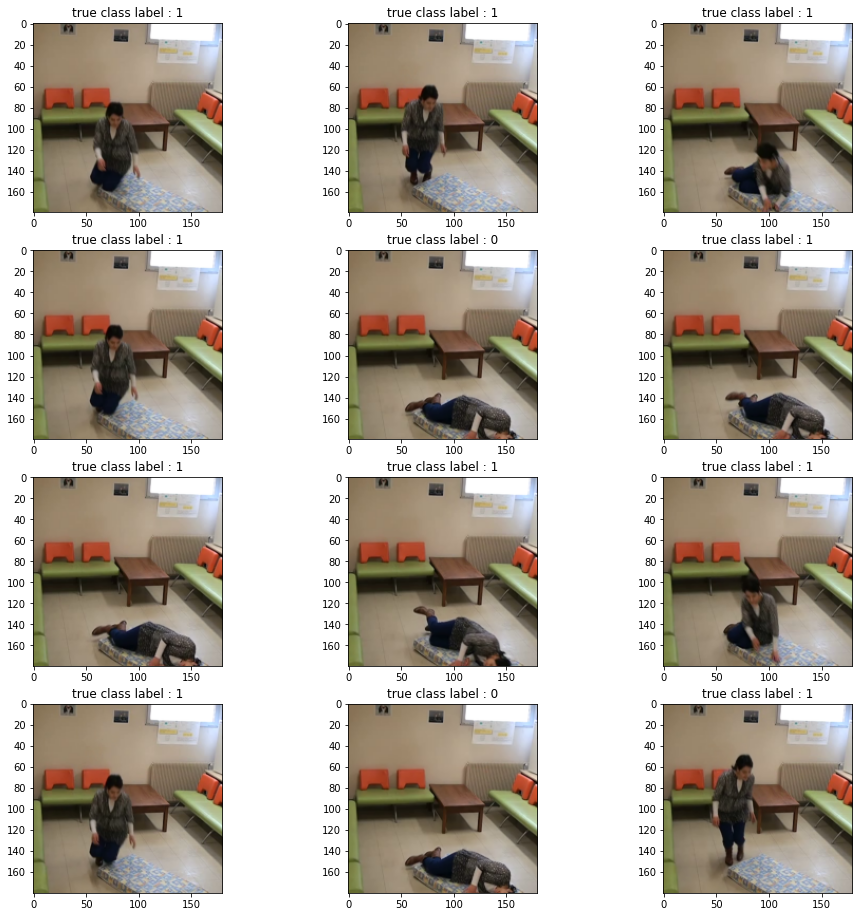

In [13]:
from matplotlib import pyplot as plt
from random import seed
from random import randint

x,y = training_generator.__getitem__(3)
print(f"current movie file index : {training_generator.movie_path_list[training_generator.current_movie_index]}")
print(f"current movie file index : {training_generator.current_movie_index}")
print(f"current video frame in movie: {training_generator.current_video_frame}")
print(f"batch : {len(x)}")
print(x.shape)

print(y)
seed(1)
columns = 3
rows = 4
fig = plt.figure(figsize=(16, 16))
for i in range(1, columns*rows +1):
    value = randint(0, training_generator.batch_size)
    img = x[value]
    b,g,r = cv2.split(img)
    rgb = cv2.merge((r,g,b))
    fig.add_subplot(rows, columns, i)
    plt.title(f"true class label : {y[value]}")
    plt.imshow(rgb)

plt.show()

## Model



### Model building

The model we wish to create can switch between default initialized bias and custom initialized bias in the last layer. As seen in the data exploration section, the dataset in very imbalanced which may result in a slow convergence.

In [65]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow import random
import keras.initializers
import tensorflow as tf 
from tensorflow import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


def get_model(optimizer, loss, output_bias=None, metrics=METRICS):

  random.set_seed(1) # make weight initialization deterministic

  # Model
  model = Sequential()
  
  model.add(Conv2D(8, (3, 3), input_shape=(180,180,3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(16, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128)) # W1*x + b
  model.add(Activation('relu')) # ReLU(W1*x + b)
  model.add(Dropout(0.5))
  if output_bias is None:
    # number of classes - softmax(W2*x + b) where b is default bias 
    model.add(Dense(1, activation='sigmoid')) 
  else:  
    # number of classes - softmax(W2*x + b) where b is carefully selected bias 
    output_bias = keras.initializers.Constant(output_bias)
    model.add(Dense(1, activation='sigmoid', bias_initializer=output_bias)) 

  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics)

  return model


### Baseline model

In [66]:
model_no_bias = get_model(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=keras.losses.BinaryCrossentropy(from_logits=False))
model_no_bias.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 178, 178, 8)       224       
                                                                 
 activation_10 (Activation)  (None, 178, 178, 8)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 176, 176, 16)      1168      
                                                                 
 activation_11 (Activation)  (None, 176, 176, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 88, 88, 16)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 88, 88, 16)        0         
                                                      

#### Baseline model training 
* Takes ~1 hour to run
* After run the model and training history is persisted to disk


In [ ]:
# Default bias start loss
model_no_bias = get_model(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=keras.losses.BinaryCrossentropy(from_logits=False))

number_of_epochs = 3
training_generator.reset()
validation_generator.reset()

history = model_no_bias.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=number_of_epochs, use_multiprocessing=False)

# persist model and data for plots
model_no_bias.save(str(p)+ "/models/modelDefaultBias3")
np.save(str(p) + '/models/history/modelDefaultBias3.npy', history.history)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1986/1986 [==============================] - 439s 220ms/step - loss: 0.1975 - tp: 0.0000e+00 - fp: 11.0000 - tn: 60624.0000 - fn: 2917.0000 - accuracy: 0.9539 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5670 - prc: 0.0587 - val_loss: 0.4316 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 10177.0000 - val_fn: 1023.0000 - val_accuracy: 0.9087 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7716 - val_prc: 0.1996
Epoch 2/3
1986/1986 [==============================] - 434s 218ms/step - loss: 0.1785 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 60634.0000 - fn: 2918.0000 - accuracy: 0.9541 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6884 - prc: 0.1096 - val_loss: 0.4314 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 10177.0000 - val_fn: 1023.0000 - val_accuracy: 0.9087 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7927 - val_prc: 0.2282
Epoch 3/3
1986/1986 [==============================] - 444s 222ms/step - loss: 0.1721 - tp: 2.0

#### Load baseline model

In [15]:
model_folder = str(p) + "/models"

model_baseline = keras.models.load_model(model_folder + "/modelDefaultBias3")
model_baseline_history= np.load(model_folder + "/history/modelDefaultBias3.npy", allow_pickle='TRUE').item()

#### Evalute Metrics

In [ ]:
baseline_results = model_baseline.evaluate(validation_generator)
for name, value in zip(model_baseline.metrics_names, baseline_results):
  print(name, ': ', value)
print()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


350/350 [==============================] - 21s 57ms/step - loss: 0.4184 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 10177.0000 - fn: 1023.0000 - accuracy: 0.9087 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8070 - prc: 0.2654
loss :  0.4183539152145386
tp :  0.0
fp :  0.0
tn :  10177.0
fn :  1023.0
accuracy :  0.9086607098579407
precision :  0.0
recall :  0.0
auc :  0.8070136308670044
prc :  0.2653898298740387



In [23]:
import random as ranplot
number_of_colors = 8

colors = ["#"+''.join([ranplot.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

def plot_metrics(history, epoch):
  fig = plt.figure(figsize=(16, 16))
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.semilogy(range(epoch), history[metric], color=colors[0], label='Train')
    plt.semilogy(range(epoch), history['val_'+metric],
             color=colors[n], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


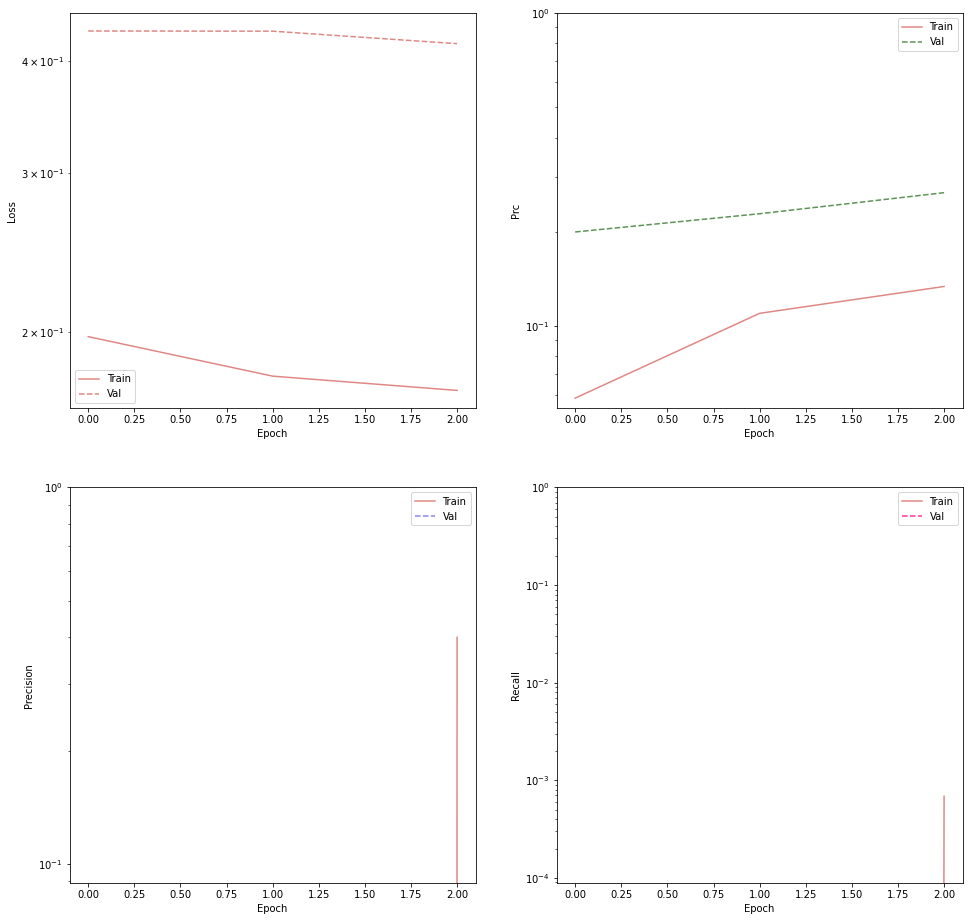

In [24]:
plot_metrics(model_baseline_history,3)

#### Confusion matrix


In [25]:
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Not falling Detected (True Negatives): ', cm[0][0])
  print('Not falling Incorrectly Detected (False Positives): ', cm[0][1])
  print('Falling Detected (False Negatives): ', cm[1][0])
  print('Falling Incorrectly Detected (True Positives): ', cm[1][1])
  print('true falling cases ', np.sum(cm[1]))

Fetch traning and testing labels, and prepare data for plots - takes 10 mins
* Predict all from validation & and training

In [106]:
validation_labels = []
validation_generator.reset()

# Fetch all true labels for validation
for batch in validation_generator:
  for label in batch[1]:
    validation_labels.append(label)


# predict labels validation
validation_generator.reset()
test_predictions = model_baseline.predict(validation_generator)

Not falling Detected (True Negatives):  10206
Not falling Incorrectly Detected (False Positives):  0
Falling Detected (False Negatives):  994
Falling Incorrectly Detected (True Positives):  0
true falling cases  994


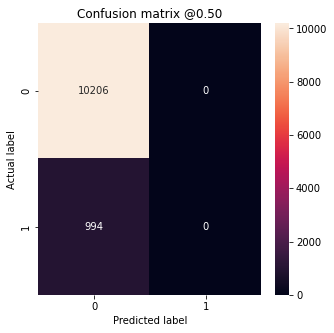

In [27]:
## Plot cm
plot_cm(validation_labels, test_predictions)

#### Plot ROC


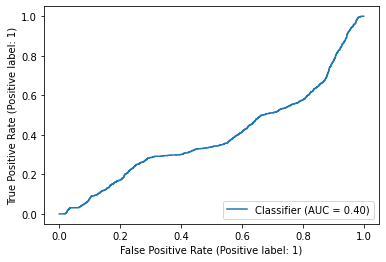

In [28]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(validation_labels, test_predictions)
plt.show() 

#### Top-1 error

In [107]:
top1 = get_top1(test_predictions,validation_labels, 0.5)
print('top1 error:',top1)

num_error / N    : 994/11200
top1 error: 0.08875


### Biased model(Selected)
* Takes ~1 hour to run
* After run the model and training history is persisted to disk

As an option to an activation function, a bias can be given. This optional bias can be calculated from the following formula:

$b_0=log_2(pos/neg)$

#### Biased model training

In [ ]:
# Samples from each distribution
total_number_of_Not_Falling =  71883
Total_number_of_Falling_samples =  4028

# Calculate 
initial_bias = np.log([Total_number_of_Falling_samples/total_number_of_Not_Falling])
print(initial_bias)

model_with_bias = get_model(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss=keras.losses.BinaryCrossentropy(from_logits=True), output_bias=initial_bias)

number_of_epochs = 3
training_generator.reset()
validation_generator.reset()

history = model_with_bias.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=number_of_epochs, use_multiprocessing=False)

# persint model and data for plots
model_with_bias.save(str(p)+ "/models/modelCalculatedBias3")
np.save(str(p) + '/models/history/modelCalculatedBias3.npy', history.history)

[-2.88176982]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1986/1986 [==============================] - 442s 221ms/step - loss: 0.1861 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 71803.0000 - fn: 3941.0000 - accuracy: 0.9480 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6378 - prc: 0.1241 - val_loss: 0.2950 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 10177.0000 - val_fn: 1023.0000 - val_accuracy: 0.9087 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7978 - val_prc: 0.2422
Epoch 2/3
1986/1986 [==============================] - 447s 223ms/step - loss: 0.1698 - tp: 1.0000 - fp: 7.0000 - tn: 60627.0000 - fn: 2917.0000 - accuracy: 0.9540 - precision: 0.1250 - recall: 3.4270e-04 - auc: 0.7407 - prc: 0.1266 - val_loss: 0.2815 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 10177.0000 - val_fn: 1023.0000 - val_accuracy: 0.9087 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8137 - val_prc: 0.2656
Epoch 3/3
1986/1986 [==============================] - 433s 216ms/step - loss: 0.1630 - tp: 3.0000 - fp:

#### Load biased model


In [29]:
model_biased = keras.models.load_model(str(p) + "/models/modelCalculatedBias3")
model_biased_history=np.load(str(p) + '/models/history/modelCalculatedBias3.npy',allow_pickle='TRUE').item()

#### Evalute Metrics



In [30]:
validation_generator.reset()

model_biased_results = model_biased.evaluate(validation_generator)
for name, value in zip(model_biased.metrics_names, model_biased_results):
  print(name, ': ', value)
print()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


350/350 [==============================] - 23s 61ms/step - loss: 0.3187 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 10174.0000 - fn: 1026.0000 - accuracy: 0.9084 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5010 - prc: 0.0910
loss :  0.31866174936294556
tp :  0.0
fp :  0.0
tn :  10174.0
fn :  1026.0
accuracy :  0.9083928465843201
precision :  0.0
recall :  0.0
auc :  0.5010319948196411
prc :  0.09095441550016403



In [104]:
validation_labels = []
validation_generator.reset()

# Fetch all true labels for validation
for batch in validation_generator:
  for label in batch[1]:
    validation_labels.append(label)


# predict labels validation
validation_generator.reset()
test_predictions = model_biased.predict(validation_generator)

#### Confusion matrix

[[0.05375501]
 [0.05349848]
 [0.05337745]
 [0.05329604]
 [0.0534284 ]]
Not falling Detected (True Negatives):  10206
Not falling Incorrectly Detected (False Positives):  0
Falling Detected (False Negatives):  994
Falling Incorrectly Detected (True Positives):  0
true falling cases  994


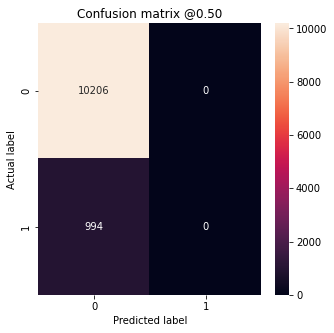

In [32]:
print(test_predictions[0:5])
plot_cm(validation_labels, test_predictions)

#### Plot ROC

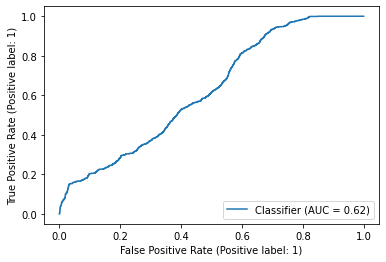

In [33]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(validation_labels, test_predictions)
plt.show() 

#### Top-1 error

In [105]:
top1 = get_top1(test_predictions,validation_labels, 0.5)
print('top1 error:',top1)

num_error / N    : 994/11200
top1 error: 0.08875


### Class weights

Another way to combat imbalanced datsets is by calculating class weights. The goal is to identify people falling, but as we dont have many positive (falling) samples to work with, we would like to have the classifier heavily weight the few examples that are available.

In [34]:
neg =  71883
pos =  4028
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight_addon = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (not-falling): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (falling): {:.2f}'.format(weight_for_1))

Weight for class 0 (not-falling): 0.53
Weight for class 1 (falling): 9.42


#### Train model with class weights


In [ ]:
# Default bias start loss
model_no_bias_w_wights = get_model(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=keras.losses.BinaryCrossentropy(from_logits=True))

number_of_epochs = 3
training_generator.reset()
validation_generator.reset()

history = model_no_bias_w_wights.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    epochs=number_of_epochs,
    use_multiprocessing=False,
    # Now with added class weights
    class_weight=class_weight_addon)

# persist model and data for plots
model_no_bias_w_wights.save(str(p)+ "/models/modelDefaultBiasWithWeights3")
np.save(str(p) + '/models/history/modelDefaultBiasWithWeights3.npy', history.history)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1986/1986 [==============================] - 424s 212ms/step - loss: 0.6622 - tp: 1256.0000 - fp: 17538.0000 - tn: 53274.0000 - fn: 2684.0000 - accuracy: 0.7295 - precision: 0.0668 - recall: 0.3188 - auc: 0.5166 - prc: 0.0651 - val_loss: 0.7166 - val_tp: 984.0000 - val_fp: 5212.0000 - val_tn: 4965.0000 - val_fn: 39.0000 - val_accuracy: 0.5312 - val_precision: 0.1588 - val_recall: 0.9619 - val_auc: 0.8049 - val_prc: 0.2459
Epoch 2/3
1986/1986 [==============================] - 408s 204ms/step - loss: 0.5687 - tp: 1876.0000 - fp: 17075.0000 - tn: 43559.0000 - fn: 1042.0000 - accuracy: 0.7149 - precision: 0.0990 - recall: 0.6429 - auc: 0.7313 - prc: 0.1197 - val_loss: 0.7199 - val_tp: 960.0000 - val_fp: 4515.0000 - val_tn: 5662.0000 - val_fn: 63.0000 - val_accuracy: 0.5913 - val_precision: 0.1753 - val_recall: 0.9384 - val_auc: 0.8066 - val_prc: 0.2483
Epoch 3/3
1986/1986 [==============================] - 415s 208ms/step - loss: 0.5367 - tp: 1972.0000 - fp: 14885.0000 - tn: 45749.0000 - 

#### Load model

In [35]:
model_folder = str(p) + "/models"

model_baseline_w_weights = keras.models.load_model(model_folder + "/modelDefaultBiasWithWeights3")
model_baseline_history_w_weights = np.load(model_folder + "/history/modelDefaultBiasWithWeights3.npy", allow_pickle='TRUE').item()

#### Evalute metrics

In [40]:
baseline_results_with_weights = model_baseline_w_weights.evaluate(validation_generator)
for name, value in zip(model_baseline_w_weights.metrics_names, baseline_results_with_weights):
  print(name, ': ', value)
print()

350/350 [==============================] - 21s 61ms/step - loss: 0.6864 - tp: 185.0000 - fp: 2171.0000 - tn: 8003.0000 - fn: 841.0000 - accuracy: 0.7311 - precision: 0.0785 - recall: 0.1803 - auc: 0.4987 - prc: 0.0930
loss :  0.6864343285560608
tp :  185.0
fp :  2171.0
tn :  8003.0
fn :  841.0
accuracy :  0.731071412563324
precision :  0.07852292060852051
recall :  0.1803118884563446
auc :  0.4987160563468933
prc :  0.09296352416276932



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


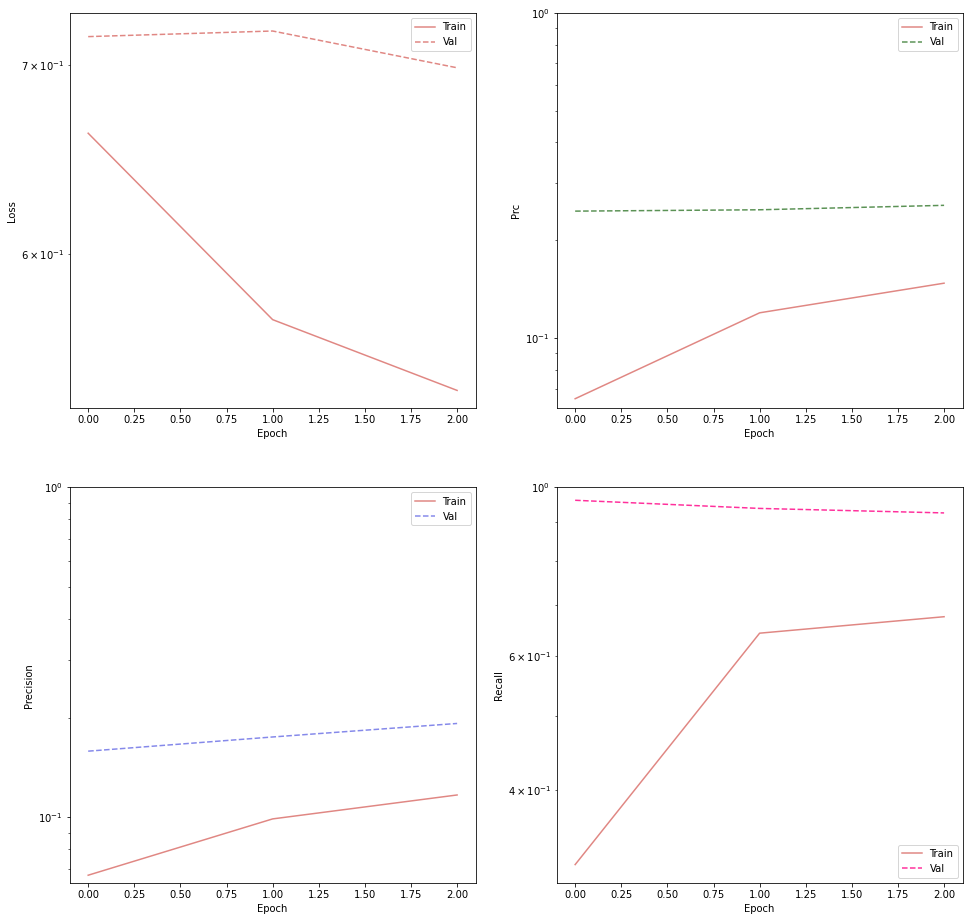

In [41]:
plot_metrics(model_baseline_history_w_weights,3)

#### Confusion matrix

In [102]:
validation_labels = []
validation_generator.reset()

# Fetch all true labels for validation
for batch in validation_generator:
  for label in batch[1]:
    validation_labels.append(label)


# predict labels validation
validation_generator.reset()
test_predictions = model_baseline_w_weights.predict_generator(validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if sys.path[0] == '':


Not falling Detected (True Negatives):  8092
Not falling Incorrectly Detected (False Positives):  2114
Falling Detected (False Negatives):  752
Falling Incorrectly Detected (True Positives):  242
true falling cases  994


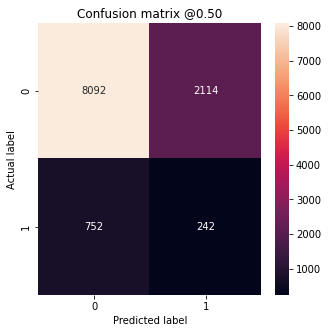

In [43]:
# Plot cm
plot_cm(validation_labels, test_predictions)

#### Plot ROC

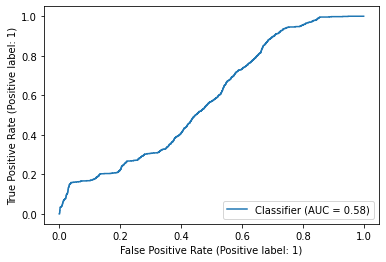

In [44]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(validation_labels, test_predictions)
plt.show() 

#### Top-1 error

In [103]:
top1 = get_top1(test_predictions,validation_labels, 0.5)
print('top1 error:',top1)

num_error / N    : 3887/11200
top1 error: 0.3470535714285714


### Transfer learning


#### Transfer model traning

In [45]:
from keras.models import Model
from keras.applications.mobilenet_v2 import MobileNetV2

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


def get_transfer_model(optimizer, loss, metrics=[keras.metrics.BinaryAccuracy()]):
  model_mobileNet = MobileNetV2(include_top=False, input_shape=(180,180,3))
  for layer in model_mobileNet.layers:
    layer.trainable = False


  flat1 = Flatten()(model_mobileNet.layers[-1].output)
  class1 = Dense(1024, activation='relu')(flat1)
  output = Dense(1, activation='sigmoid')(class1)

  revised_model = Model(inputs=model_mobileNet.inputs, outputs=output)

  revised_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)
   
  return revised_model

#### Create generators

In [58]:
# Parameters
params = {'batch_size': 32,
          'dim': (180,180),
          'n_channels': 3,
          'n_classes': 2, 
          'shuffle': True,
          'preprocessor': True}

# Generators
training_generator = FallingDataGenerator(partition['Training'][0], partition['Training'][1], **params)
validation_generator = FallingDataGenerator(partition['Validation'][0], partition['Validation'][1], **params)

In [59]:
neg =  71883
pos =  4028
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight_addon = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (not-falling): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (falling): {:.2f}'.format(weight_for_1))

Weight for class 0 (not-falling): 0.53
Weight for class 1 (falling): 9.42


In [ ]:
# Default bias start loss
transfer_model_no_bias_w_wights = get_transfer_model(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=keras.losses.BinaryCrossentropy(from_logits=False))

## avoid overfit
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

number_of_epochs = 10
training_generator.reset()
validation_generator.reset()

history = transfer_model_no_bias_w_wights.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    epochs=number_of_epochs,
    use_multiprocessing=False,
    callbacks=[callback],
    # Now with added class weights
    class_weight=class_weight_addon)


# persist model and data for plots
transfer_model_no_bias_w_wights.save(str(p)+ "/models/modelDefaultTransfer")
np.save(str(p) + '/models/history/modelDefaultTransfer.npy', history.history)

9420800/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
1986/1986 [==============================] - 495s 244ms/step - loss: 1.2882 - binary_accuracy: 0.7399 - val_loss: 0.4910 - val_binary_accuracy: 0.7876
Epoch 2/10
1986/1986 [==============================] - 499s 251ms/step - loss: 0.4450 - binary_accuracy: 0.8502 - val_loss: 1.1452 - val_binary_accuracy: 0.7408
Epoch 3/10
1986/1986 [==============================] - 480s 241ms/step - loss: 0.3666 - binary_accuracy: 0.8733 - val_loss: 0.3858 - val_binary_accuracy: 0.8444
Epoch 4/10
1986/1986 [==============================] - 496s 250ms/step - loss: 0.3439 - binary_accuracy: 0.8868 - val_loss: 0.4695 - val_binary_accuracy: 0.8735
Epoch 5/10
1986/1986 [==============================] - 478s 240ms/step - loss: 0.5312 - binary_accuracy: 0.8800 - val_loss: 0.6337 - val_binary_accuracy: 0.8493
Epoch 6/10
1986/1986 [==============================] - 471s 237ms/step - loss: 0.5930 - binary_accuracy: 0.8770 - val_loss: 1.1503 - val_binary_accuracy: 0.7738
INFO:tensorflow:Assets writt

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


#### Load model

In [60]:
transfer_model_no_bias_w_wights = keras.models.load_model(str(p) + "/models/modelDefaultTransfer")
transfer_model_no_bias_w_wights_history =np.load(str(p) + '/models/history/modelDefaultTransfer.npy',allow_pickle='TRUE').item()

#### Evalute metrics

In [61]:
transfer_model_no_bias_w_wights_result = transfer_model_no_bias_w_wights.evaluate(validation_generator)
for name, value in zip(transfer_model_no_bias_w_wights.metrics_names, transfer_model_no_bias_w_wights_result):
  print(name, ': ', value)
print()

350/350 [==============================] - 34s 94ms/step - loss: 1.1134 - binary_accuracy: 0.7862
loss :  1.1134222745895386
binary_accuracy :  0.7862499952316284



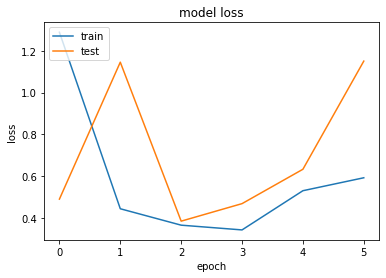

In [71]:
plt.plot(transfer_model_no_bias_w_wights_history['loss'])
plt.plot(transfer_model_no_bias_w_wights_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
validation_labels = []
validation_generator.reset()

# Fetch all true labels for validation
for batch in validation_generator:
  for label in batch[1]:
    validation_labels.append(label)


# predict labels validation
validation_generator.reset()
test_predictions_transfer = transfer_model_no_bias_w_wights.predict_generator(validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if sys.path[0] == '':


Not falling Detected (True Negatives):  7830
Not falling Incorrectly Detected (False Positives):  2376
Falling Detected (False Negatives):  156
Falling Incorrectly Detected (True Positives):  838
true falling cases  994


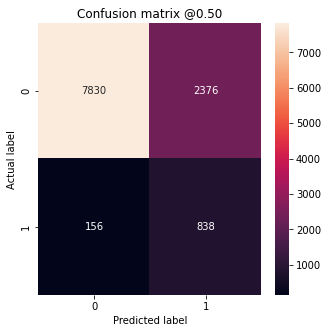

In [63]:
#Plot cm
plot_cm(validation_labels, test_predictions_transfer)

#### Plot ROC

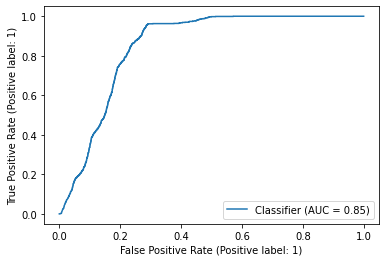

In [73]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(validation_labels, test_predictions_transfer)
plt.show() 

#### Precision & Recall

In [75]:
proba = 0.50
tn, fp, fn, tp = confusion_matrix(validation_labels, test_predictions_transfer > proba).ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print(f"Precision : {precision}")
print(f"recall : {recall}")

Precision : 0.26073428749222155
recall : 0.8430583501006036


#### Top-1 error 

In [ ]:
# Top-1 error
def get_top1(predictions_class,y_test_class, p):
  N = len(predictions_class)
  num_error = 0
  for i in range(N):
    if predictions_class[i] > p and y_test_class[i] == 0:
      num_error += 1
    if  predictions_class[i] < p and y_test_class[i] == 1:
      num_error += 1 
  print(f"num_error / N    : {num_error}/{N}")    
  return num_error / N

In [101]:
top1 = get_top1(test_predictions_transfer,validation_labels, proba)
print('top1 error:',top1)

num_error / N    : 2532/11200
top1 error: 0.22607142857142856


### TODO
* **Search about class imbalance**
  * Binary classifier, where we can edit wiegted loss W_1*l0 + W_2*l1 where W_2 counts for more since, we dont have that much falling data
* **Modify own datagenereator**
  * Oversampling/undersampling
  * Oversampling: **bold text** Instead of taking next 32 frames, we should take 16,16 of each class(falling/not falling) and oversampling from the falling distribution, since we dont have that many
  * **Data augmentation**:
  * Augment the falling distribution since we dont have that many samples
* **Look into what crossvalidation is**